In [ ]:
import pandas as pd
import csv
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sb
import numpy as np
import regex as re
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as metrics
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pickle

In [ ]:
#loading dataset
test_filename = '/content/test.csv'
train_filename = '/content/train.csv'
valid_filename = '/content/valid.csv'

train_news = pd.read_csv(train_filename)
test_news = pd.read_csv(test_filename)
valid_news = pd.read_csv(valid_filename)

In [ ]:
#data observation
def data_obs():
    print("training dataset size:")
    print(train_news.shape)
    print(train_news.head(5))

    #below dataset were used for testing and validation purposes
    print(test_news.shape)
    print(test_news.head(5))
    
    print(valid_news.shape)
    print(valid_news.head(5))

#check the data by calling below function
data_obs()

training dataset size:
(10240, 2)
                                           Statement  Label
0  Says the Annies List political group supports ...  False
1  When did the decline of coal start? It started...   True
2  Hillary Clinton agrees with John McCain "by vo...   True
3  Health care reform legislation is likely to ma...  False
4  The economic turnaround started at the end of ...   True
(2551, 2)
                                           Statement  Label
0  Building a wall on the U.S.-Mexico border will...   True
1  Wisconsin is on pace to double the number of l...  False
2  Says John McCain has done nothing to help the ...  False
3  Suzanne Bonamici supports a plan that will cut...   True
4  When asked by a reporter whether hes at the ce...  False
(2571, 2)
                                           Statement  Label
0  We have less Americans working now than in the...  FALSE
1  When Obama was sworn into office, he DID NOT u...  FALSE
2  Says Having organizations parading as being

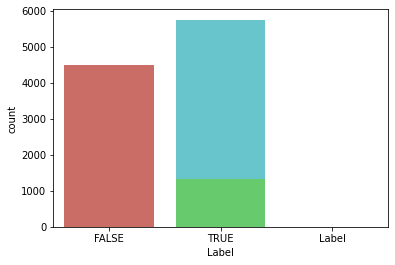

In [ ]:
#distribution of classes for prediction
def create_distribution(dataFile):
    
    return sb.countplot(x='Label', data=dataFile, palette='hls')
    

#by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_news)
create_distribution(test_news)
create_distribution(valid_news)

In [ ]:
import nltk
nltk.download('stopwords')
eng_stemmer = PorterStemmer()
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#stopwords in 'english'
print(stopwords)

{"aren't", 'by', 'during', 'off', 'only', "weren't", 'once', 'wouldn', "hadn't", "isn't", 'were', 'will', 'be', 'they', 'he', "you'd", 'yours', 'yourself', 'theirs', "it's", 'into', 'ma', 'until', 'll', 'doing', 'now', 'the', 'than', 'having', 'needn', 'has', 'more', 'any', 't', "doesn't", 'being', 'after', 'should', "she's", 'did', "needn't", "you're", 'itself', 'too', 'm', 'these', 'and', "wouldn't", 'between', 'himself', 'hers', 'or', 'my', 'down', 'nor', 'didn', 'just', 'your', 'her', 're', 'each', 'those', 'no', 'up', 'that', "hasn't", 'mightn', 'you', "you'll", 'through', 'of', "didn't", 'on', 'can', 'why', 'but', 'was', 'does', 'further', 'at', 'herself', 'if', 'this', 'them', 've', 'his', 'in', 'it', "won't", 'other', 'are', 'below', 'shouldn', 'haven', 'above', 'their', 'hasn', 'with', 'am', 'is', "that'll", 'under', 'had', 'an', 'some', 'because', 'both', 'do', 'him', 'themselves', 'how', 'own', 'couldn', "don't", 'ours', 'not', 'shan', 'here', 'won', 'when', 'who', 'aren', '

In [ ]:
#preprocess data: remove punctuations
def preprocess(text, pattern):
    if pattern=='[.]+':
        text = re.sub(pattern, '. ', text)
    elif pattern =="[']" or pattern == "[/w+-/w+]":
        text =  re.sub(pattern, ' ', text)
    else:
        text = re.sub(pattern, '', text)
    #print(text, '\n')
    return text

In [ ]:
#train_data removing punctuations
train_news['Statement'] = np.vectorize(preprocess)(train_news['Statement'], '[.]+')
train_news['Statement'] = np.vectorize(preprocess)(train_news['Statement'], "[']")
train_news['Statement']= np.vectorize(preprocess)(train_news['Statement'], "[/w+-/w+]")
train_news['Statement'] = np.vectorize(preprocess)(train_news['Statement'], '[^\w\s]*')


In [ ]:
#train_data after removing punctuations
train_news['Statement'][0]

'Says the Annies List political group supports third trimester abortions on demand  '

In [ ]:
#process the data 
#tokenize,stemming and remove stop words
def process_data(data):
    tokens = []
    tokens = data.lower().split()
    tokens_stemmed = []
    for word in tokens:
      if word not in stopwords:
        tokens_stemmed.append(eng_stemmer.stem(word))
    sentence = ' '.join(tokens_stemmed)
    return sentence

In [ ]:
train_news['Statement'] = np.vectorize(process_data)(train_news['Statement'])

In [ ]:
#train_data after stemming
train_news['Statement'].head()

0    say anni list polit group support third trimes...
1    declin coal start start hen natur ga took star...
2    hillari clinton agre ith john mccain vote give...
3    health care reform legisl like mandat free sex...
4                     econom turnaround start end term
Name: Statement, dtype: object

In [ ]:
#test_data set removing punctuations
test_news['Statement'] = np.vectorize(preprocess)(test_news['Statement'], '[.]+')
test_news['Statement'] = np.vectorize(preprocess)(test_news['Statement'], "[']")
test_news['Statement']= np.vectorize(preprocess)(test_news['Statement'], "[/w+-/w+]")
test_news['Statement'] = np.vectorize(preprocess)(test_news['Statement'], '[^\w\s]*')

In [ ]:
#test_data after removing punctuations
test_news['Statement'][0]

'Building a  all on the U  S   Mexico border  ill take literally years  '

In [ ]:
test_news['Statement'] = np.vectorize(process_data)(test_news['Statement'])

In [ ]:
#test_data after stemming
test_news['Statement'].head()

0            build u mexico border ill take liter year
1              wisconsin pace doubl number layoff year
2                   say john mccain done noth help vet
3    suzann bonamici support plan ill cut choic med...
4    ask report hether he center crimin scheme viol...
Name: Statement, dtype: object

In [ ]:
#valid_data set removing punctuations
valid_news['Statement'] = np.vectorize(preprocess)(valid_news['Statement'], '[.]+')
valid_news['Statement'] = np.vectorize(preprocess)(valid_news['Statement'], "[']")
valid_news['Statement']= np.vectorize(preprocess)(valid_news['Statement'], "[/w+-/w+]")
valid_news['Statement'] = np.vectorize(preprocess)(valid_news['Statement'], '[^\w\s]*')

In [ ]:
#valid_data after removing punctuations
valid_news['Statement'][0]

'We have less Americans  orking no  than in the 70s  '

In [ ]:
valid_news['Statement'] = np.vectorize(process_data)(valid_news['Statement'])

In [ ]:
#valid_data after stemming
valid_news['Statement'].head()

0                                 less american ork 70
1    obama orn offic use holi bibl instead kuran eq...
2    say organ parad social elfar organ involv poli...
3                 say nearli half oregon children poor
4    attack republican variou program econom stimul...
Name: Statement, dtype: object

In [ ]:
#feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_ngram = TfidfVectorizer(stop_words = 'english', ngram_range=(1,4),use_idf=True,smooth_idf=True)

In [ ]:
tfidf_ngram

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
#User defined functon for K-Fold cross validatoin
def build_confusion_matrix(classifier):
    
    k_fold = KFold(n_splits=5)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(train_news):
        train_text = train_news.iloc[train_ind]['Statement'] 
        train_y = train_news.iloc[train_ind]['Label']
    
        test_text = train_news.iloc[test_ind]['Statement']
        test_y = train_news.iloc[test_ind]['Label']
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        scores.append(score)
    
    return (print('Total statements classified:', len(train_news)),
    print('Score:', sum(scores)/len(scores)),
    print('score length', len(scores)),
    print('Confusion matrix:'),
    print(confusion))
 

In [ ]:
##Now using n-grams
#naive-bayes classifier
nb_pipeline_ngram = Pipeline([('nb_tfidf',tfidf_ngram),('nb_clf',MultinomialNB())])

nb_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_nb_ngram = nb_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_nb_ngram == test_news['Label'])

build_confusion_matrix(nb_pipeline_ngram)

Total statements classified: 10240
Score: 0.7224053159841455
score length 5
Confusion matrix:
[[ 758 3730]
 [ 390 5362]]


(None, None, None, None, None)

In [ ]:
#logistic regression classifier
logR_pipeline_ngram = Pipeline([('LogR_tfidf',tfidf_ngram),('LogR_clf',LogisticRegression(penalty="l2",C=1))])

logR_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_LogR_ngram = logR_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_LogR_ngram == test_news['Label'])

build_confusion_matrix(logR_pipeline_ngram)

Total statements classified: 10240
Score: 0.7044355553757985
score length 5
Confusion matrix:
[[1580 2908]
 [1043 4709]]


(None, None, None, None, None)

In [ ]:
#linear SVM classifier
svm_pipeline_ngram = Pipeline([('svm_tfidf',tfidf_ngram),('svm_clf',svm.LinearSVC())])

svm_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_svm_ngram = svm_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_svm_ngram == test_news['Label'])

build_confusion_matrix(svm_pipeline_ngram)

Total statements classified: 10240
Score: 0.6790920142902143
score length 5
Confusion matrix:
[[2016 2472]
 [1524 4228]]


(None, None, None, None, None)

In [ ]:
#random forest classifier
random_forest_ngram = Pipeline([('rf_tfidf',tfidf_ngram),('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=3))])
    
random_forest_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_rf_ngram = random_forest_ngram.predict(test_news['Statement'])
np.mean(predicted_rf_ngram == test_news['Label'])

build_confusion_matrix(random_forest_ngram)

Total statements classified: 10240
Score: 0.6621097130357407
score length 5
Confusion matrix:
[[1984 2504]
 [1666 4086]]


(None, None, None, None, None)

In [ ]:
print(classification_report(test_news['Label'], predicted_nb_ngram))

              precision    recall  f1-score   support

       False       0.67      0.14      0.23      1169
        True       0.56      0.94      0.71      1382

    accuracy                           0.57      2551
   macro avg       0.62      0.54      0.47      2551
weighted avg       0.61      0.57      0.49      2551



In [ ]:
print(classification_report(test_news['Label'], predicted_LogR_ngram))

              precision    recall  f1-score   support

       False       0.60      0.35      0.45      1169
        True       0.60      0.80      0.68      1382

    accuracy                           0.60      2551
   macro avg       0.60      0.58      0.56      2551
weighted avg       0.60      0.60      0.57      2551



In [ ]:
print(classification_report(test_news['Label'], predicted_svm_ngram))

              precision    recall  f1-score   support

       False       0.56      0.44      0.50      1169
        True       0.60      0.71      0.65      1382

    accuracy                           0.59      2551
   macro avg       0.58      0.58      0.57      2551
weighted avg       0.58      0.59      0.58      2551



In [ ]:
print(classification_report(test_news['Label'], predicted_rf_ngram))

              precision    recall  f1-score   support

       False       0.55      0.38      0.45      1169
        True       0.58      0.74      0.65      1382

    accuracy                           0.57      2551
   macro avg       0.57      0.56      0.55      2551
weighted avg       0.57      0.57      0.56      2551



In [ ]:
"""
Out of all the models fitted, we would take 2 best performing model. we would call them candidate models
from the confusion matrix, we can see that random forest and logistic regression are best performing 
in terms of precision and recall (take a look into false positive and true negative counts which appeares
to be low compared to rest of the models)
"""

In [ ]:
#grid-search parameter optimization
#random forest classifier parameters
parameters = {'rf_tfidf__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               'rf_tfidf__use_idf': (True, False),
               'rf_clf__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15)
}

gs_clf = GridSearchCV(random_forest_ngram, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_news['Statement'][:10000],train_news['Label'][:10000])

In [ ]:
print(gs_clf.best_score_)

0.5677


In [ ]:
print(gs_clf.best_params_)

{'rf_clf__max_depth': 15, 'rf_tfidf__ngram_range': (1, 1), 'rf_tfidf__use_idf': False}


In [ ]:
#grid-search parameter optimization
#logistic regression parameters
parameters = {'LogR_tfidf__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               'LogR_tfidf__use_idf': (True, False),
               'LogR_tfidf__smooth_idf': (True, False)
}

gs_clf = GridSearchCV(logR_pipeline_ngram, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_news['Statement'][:10000],train_news['Label'][:10000])

In [ ]:
print(gs_clf.best_score_)

0.6119


In [ ]:
print(gs_clf.best_params_)

{'LogR_tfidf__ngram_range': (1, 5), 'LogR_tfidf__smooth_idf': True, 'LogR_tfidf__use_idf': True}


In [ ]:
#by running above commands we can find the model with best performing parameters

In [ ]:
#running both random forest and logistic regression models again with best parameter found with GridSearch method
random_forest_final = Pipeline([
        ('rf_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,3),use_idf=True,smooth_idf=True)),
        ('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=3,max_depth=10))
        ])
    
random_forest_final.fit(train_news['Statement'],train_news['Label'])
predicted_rf_final = random_forest_final.predict(test_news['Statement'])
np.mean(predicted_rf_final == test_news['Label'])
print(metrics.classification_report(test_news['Label'], predicted_rf_final))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      1169
        True       0.54      1.00      0.70      1382

    accuracy                           0.54      2551
   macro avg       0.27      0.50      0.35      2551
weighted avg       0.29      0.54      0.38      2551



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
logR_pipeline_final = Pipeline([
        #('LogRCV',countV_ngram),
        ('LogR_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,5),use_idf=True,smooth_idf=False)),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])

logR_pipeline_final.fit(train_news['Statement'],train_news['Label'])
predicted_LogR_final = logR_pipeline_final.predict(test_news['Statement'])
np.mean(predicted_LogR_final == test_news['Label'])
#accuracy = 0.62
print(metrics.classification_report(test_news['Label'], predicted_LogR_final))

              precision    recall  f1-score   support

       False       0.61      0.34      0.44      1169
        True       0.59      0.82      0.69      1382

    accuracy                           0.60      2551
   macro avg       0.60      0.58      0.56      2551
weighted avg       0.60      0.60      0.57      2551



In [ ]:
"""
by running both random forest and logistic regression with GridSearch's best parameter estimation, we found that for random 
forest model with n-gram has better accuracty than with the parameter estimated. The logistic regression model with best parameter 
has almost similar performance as n-gram model so logistic regression will be out choice of model for prediction.
"""

#saving best model to the disk
model_file = 'final_model.sav'
pickle.dump(logR_pipeline_ngram,open(model_file,'wb'))

In [ ]:
var = input("Please enter the news text you want to verify: ")
print("You entered: " + str(var))


#function to run for prediction
def detecting_fake_news(var):    
#retrieving the best model for prediction call
    load_model = pickle.load(open('final_model.sav', 'rb'))
    prediction = load_model.predict([var])
    prob = load_model.predict_proba([var])

    return (print("The given statement is ",prediction[0]),
        print("The truth probability score is ",prob[0][1]))


if __name__ == '__main__':
    detecting_fake_news(var)

Please enter the news text you want to verify: Donald Trump is against marriage equality. He wants to go back.
You entered: Donald Trump is against marriage equality. He wants to go back.
The given statement is  True
The truth probability score is  0.6053158290155631
